In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix
from scipy.stats import poisson, norm
from sklearn.decomposition import PCA
import sys
sys.path.append("/home/camp/warnert")
sys.path.append("/home/camp/warnert/working/Recordings/binary_pulses/blip_manuscript")
import blip_analysis_manu as ba
import exp_blip_models_manu as em
import scipy.io as sio
import binary_recording as br
from mpl_toolkits.axes_grid1 import make_axes_locatable
import daskify
from scipy.stats import skewnorm, mannwhitneyu
import scipy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
import matplotlib
from matplotlib.gridspec import GridSpec
import openephys as oe
import os

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rcParams['savefig.pad_inches'] = 0.1



Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 1408 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 4608 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 4288 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 1440 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 5328 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 5328 trials in trial name file
Respiration peaks found
Found file

In [2]:
recs = ba.recs

In [3]:
unit_counts = [len(i.get_good_clusters()) for i in recs.recordings]

In [4]:
print(np.cumsum(unit_counts))

[ 10  31  41  63  86  92 118 145]


In [5]:
glyphs = []
for i in ba.get_trial_array():
    glyph_str = ''
    for j in i:
        if j == 1:
            glyph_str+='\u25AE'
        else:
            glyph_str += '\u25AF'



    glyphs.append(glyph_str)


In [6]:
units_usrt1 = ba.get_usrts(1, pre_trial_window=0.5, post_trial_window=0.5)
units_usrt2 = ba.get_usrts(3, pre_trial_window=0.5, post_trial_window=0.5)
units_usrt3 = ba.get_usrts(5, pre_trial_window=0.5, post_trial_window=0.5)

/home/camp/warnert/neurolytics/joined_recording.py:79: UserWarning: Mismatch in repeat lengths, cannot make full numpy array
  warnings.warn('Mismatch in repeat lengths, cannot make full numpy array')


In [7]:
mean_usrt1 = np.array([[np.mean(i, axis=0) for i in j] for j in units_usrt1])
mean_usrt2 = np.array([[np.mean(i, axis=0) for i in j] for j in units_usrt2])
mean_usrt3 = np.array([[np.mean(i, axis=0) for i in j] for j in units_usrt3])

In [8]:
select_trials = [31, 30, 28, 24, 16, 8, 4, 2, 1, 0]


Text(17, -2, '▯▯▯▯▯')

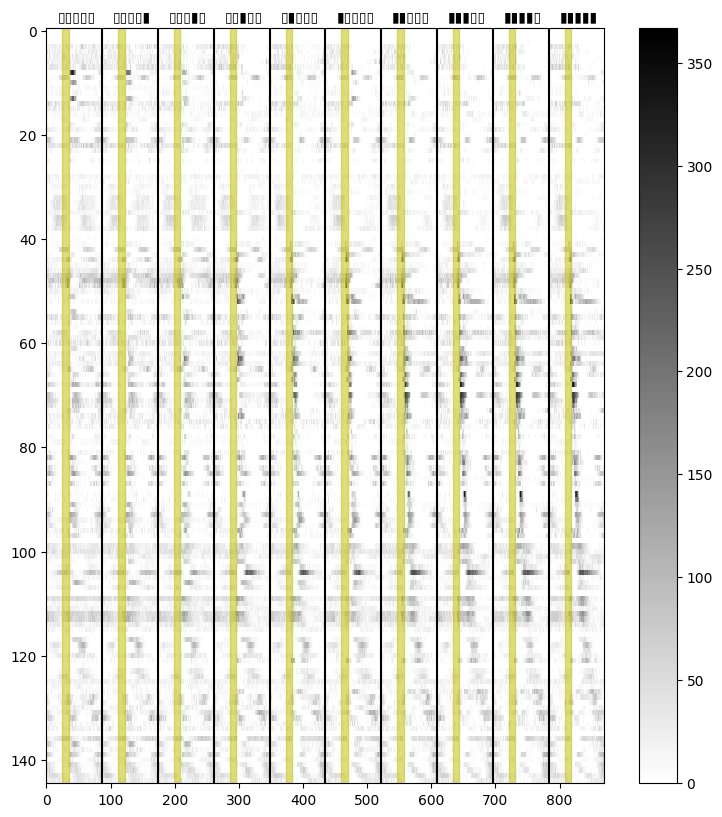

In [7]:
plt.figure(figsize=(9, 10), dpi=100)

sorted_args = np.argsort(np.argmax(mean_usrt1[:, select_trials[::-1][-1]], axis=-1))

plt.imshow(mean_usrt1[sorted_args][:, select_trials[::-1], 25:].reshape(145, -1), cmap='binary', aspect='auto')
plt.axvspan(25, 35, color='y', alpha=0.5)
for i in range(1, 10):
    plt.axvline(87*i, color='k')
    plt.axvspan(25+87*i, 35+87*i, color='y', alpha=0.5)
    plt.text(17+87*i, -2, glyphs[select_trials[::-1][i]])
plt.colorbar()
plt.text(17, -2, glyphs[select_trials[-1]])

In [9]:
def plot_psth(fig, gs, usrt, selected_trials, ui, xs, cmap='RdYlGn', resp=None):
    mean_usrt = [np.mean(i, axis=0) for i in usrt[ui]]
    std_usrt = [np.std(i, axis=0) for i in usrt[ui]]
    if resp is None:
        sub_gridspec = gs.subgridspec(ncols=1, nrows=2, hspace=.1)
        ax1 = fig.add_subplot(sub_gridspec[0])
        ax2 = fig.add_subplot(sub_gridspec[1])
    else:
        sub_gridspec = gs.subgridspec(ncols=1, nrows=5, hspace=.1)
        resp_ax = fig.add_subplot(sub_gridspec[0])
        ax1 = fig.add_subplot(sub_gridspec[1:3])
        ax2 = fig.add_subplot(sub_gridspec[3:5])
        xs_resp = np.arange(-.5, .62, 1/30000)
        resp_ax.plot(xs_resp, resp, color='k')
        resp_ax.axvspan(0, 0.1, color='lightgray')
        resp_ax.set_yticks([])
        resp_ax.spines['top'].set_visible(False)
        resp_ax.spines['right'].set_visible(False)
        resp_ax.spines['left'].set_visible(False)
        resp_ax.set_xticklabels([])
    selected_trials = selected_trials[::-1]

    count = 0
    ax1.plot(xs, mean_usrt[0], color='k', linestyle='--')
    ax2.plot(xs, mean_usrt[0], color='k', linestyle='--')
    for index, i in enumerate(selected_trials[1:6]):
        ax1.plot(xs, mean_usrt[i], color=matplotlib.cm.get_cmap(cmap)(index/(len(selected_trials)-1)))
        count += 1
    count -= 1
    for index, i in enumerate(selected_trials[5:]):
        ax2.plot(xs, mean_usrt[i], color=matplotlib.cm.get_cmap(cmap)((index+count)/(len(selected_trials)-1)))
    
    ax1_lims = ax1.get_ylim()
    ax2_lims = ax2.get_ylim()
    ylim_max = np.max([ax1_lims, ax2_lims])
    ylim_min = np.min([ax1_lims, ax2_lims])
    ylim = [ylim_min, ylim_max]
    ax1.axvspan(0, 0.1, color='lightgray')
    ax2.axvspan(0, 0.1, color='lightgray')
    ax1.set_ylim(ylim)
    ax2.set_ylim(ylim)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.set_xticklabels([])



In [10]:
rec = recs.recordings[-2]
resp_chan = oe.loadContinuous2(os.path.join(rec.home_dir, rec.resp_channel))['data']


In [11]:
tis = [100, 150, 300, 500]

In [12]:
filt_snips = []
for ti in tis:
    pre_window=0.5
    post_window=0.62
    fs=30000
    resp_snip = resp_chan[int(rec.trial_starts[ti]-pre_window*fs):int(rec.trial_starts[ti]+post_window*fs)]
    sos = scipy.signal.butter(3, 100, output='sos', fs=fs)
    filt_snip = scipy.signal.sosfiltfilt(sos, resp_snip)
    filt_snips.append(filt_snip)

In [86]:
print(len(filt_snip))

33600


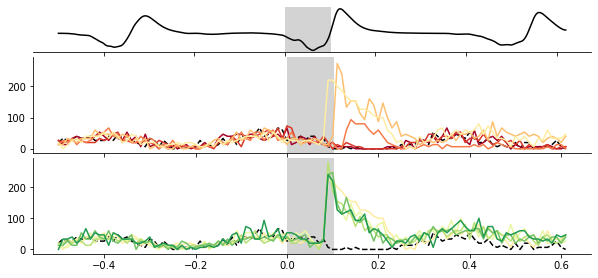

In [13]:
fig = plt.figure(figsize=(10, 10))
gs = matplotlib.gridspec.GridSpec(2, 1)

xs = np.arange(-.5, .62, 1/100)[:-1]
# sub_gridspec = gs[0].subgridspec(ncols=1, nrows=2, hspace=0)
# ax1 = fig.add_subplot(sub_gridspec[0])
# ax2 = fig.add_subplot(sub_gridspec[1])
plot_psth(fig, gs[0], units_usrt1, select_trials, 42, xs, resp=filt_snip)

In [14]:
def dendo_and_heatmaps(fig, gs, link, summed_response):
    
    sub_gridspec = gs.subgridspec(1, 2, wspace=0.1)
    sub_sub_gridspec = sub_gridspec[0].subgridspec(1, 2, wspace=0.0)

    dend_ax = fig.add_subplot(sub_sub_gridspec[0])
    dend = dendrogram(link, ax=dend_ax, orientation='left', truncate_mode=None, no_labels=True)
    dend_ax.set_ylabel('Units')
    dend_ax.set_xlabel('Distance')
    norm_heatmap_ax = fig.add_subplot(sub_sub_gridspec[1])
    resp_heatmap_ax = fig.add_subplot(sub_gridspec[1])
    im = norm_heatmap_ax.imshow(summed_response[dend['leaves'][::-1]]/np.max(summed_response, axis=-1)[dend['leaves'][::-1], np.newaxis], cmap='pink', aspect='auto')
#     plt.colorbar(mappable=im, ax=norm_heatmap_ax, aspect=40)
    norm_heatmap_ax.set_xticks(range(32))
    norm_heatmap_ax.set_xticklabels(glyphs, rotation=90);
    norm_heatmap_ax.set_yticks([])
    divider = make_axes_locatable(norm_heatmap_ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    plt.colorbar(im, cax=cax)
#    heatmap_cbar_ax = fig.add_subplot(sub_gridspec[39])
    plot_heatmap(resp_heatmap_ax, mean_usrt1, select_trials, dend['leaves'][::-1])
 #   normed_cbar_ax = fig.add_subplot(sub_gridspec[37])
#    plt.colorbar(mappable=im, cax=normed_cbar_ax)

def plot_heatmap(ax, mean_usrt, select_trials, sorted_args=None, time_offset=25, cmap='binary', time_ticks_base = None, colorbar_ax=None):  
    if sorted_args is None:
        sorted_args = np.argsort(np.argmax(mean_usrt[:, select_trials[::-1][-1]], axis=-1))
    im = ax.imshow(mean_usrt[sorted_args][:, select_trials[::-1], time_offset:].reshape(145, -1), cmap=cmap, aspect='auto')
    ax.axvspan(50-time_offset, 50-time_offset+10, color='y', alpha=0.2)
    time_len = mean_usrt.shape[-1] - time_offset
    if time_ticks_base is None:
        pre_window = time_offset/100 - .5
        post_window = time_len/100 + pre_window
        
        time_ticks_base = np.arange(pre_window, post_window, -1*pre_window)
    
    full_xs = np.arange(time_offset/100-.5, time_len/100, 1/100).round(2)
    print(full_xs.round(2))
    xticks_base = np.array([np.where(full_xs == i)[0][0] for i in time_ticks_base])
    
 #   xticks_base = np.linspace(0, time_len, int(pre_window*-100))
    print(xticks_base)
    time_ticks = []
    xticks = []
    for i in range(len(select_trials)):
        xticks.append(xticks_base+i*time_len)
        time_ticks.append(time_ticks_base)

    ax.set_xticks(np.concatenate(xticks))
    
    ax.set_xticklabels(np.concatenate(time_ticks), rotation=90)
    for i in range(1, 10):
        ax.axvline(87*i, color='k')
        ax.axvspan(25+87*i, 35+87*i, color='y', alpha=0.2)
        ax.text(17+87*i, -2, glyphs[select_trials[::-1][i]])
    if colorbar_ax is None:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='2.5%', pad=0.05)
        plt.colorbar(mappable=im, cax=cax)
    else:
        plt.colorbar(mappable=im, cax=colorbar_ax)
    ax.text(17, -2, glyphs[select_trials[-1]])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Units')

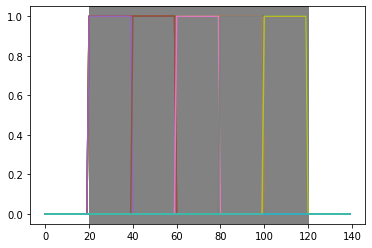

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
plots_all = [br.binary_plotter(i, ax=ax) for i in select_trials]


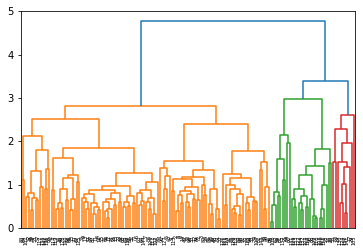

In [16]:
summed_response1 = mean_usrt1[:, :, 50:100].sum(axis=-1)
summed_response2 = mean_usrt2[:, :, 50:100].sum(axis=-1)
summed_response3 = mean_usrt3[:, :, 50:100].sum(axis=-1)
link = linkage(summed_response1/np.max(summed_response1, axis=-1)[:, np.newaxis], optimal_ordering=True, method='complete', )
dend = dendrogram(link)

[-0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14
 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02
 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1
  0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22
  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34
  0.35  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46
  0.47  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58
  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7
  0.71  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8   0.81  0.82
  0.83  0.84  0.85  0.86  0.87]
[ 0 25 50 75]


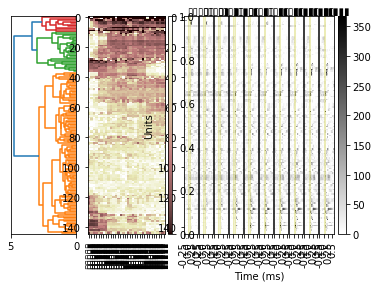

In [17]:
fig = plt.figure()
gs = matplotlib.gridspec.GridSpec(1, 1)
dendo_and_heatmaps(fig, gs[0], link, summed_response1)

In [17]:
def stimuli_plot(ax, stim_plots):
    for index, i in enumerate(stim_plots[:-1][::-1]):
        ax.step(range(len(i)), i-index*1.5, color=matplotlib.cm.RdYlGn(index/(len(stim_plots)-1)))
    ax.axis('off')
    ax.axvspan(20, 120, color='lightgray')
    return ax
def stimuli_plot_glyphs(ax, glyphs, select_trials):
    for index, i in enumerate(select_trials[:-1][::-1]):
        ax.text(0.6, .9-index/(len(select_trials)-1), glyphs[i], color=matplotlib.cm.RdYlGn(index/(len(select_trials)-1)), fontsize=20)
    ax.axis('off')
    return ax

In [19]:
### Getting the PID and flow recording
odour_path = "/home/camp/warnert/working/Recordings/Set up recordings/200615 - Binary pulse calibration/"


EB_trials = open(odour_path + '2020-06-15trial_name_flowmeter_EB_2.txt', 'r').readlines()
trial_order = []
for i in EB_trials:
    if ':' not in i:
        trial_order.append(i.split('_')[1][:-1])
EB_flows = sio.loadmat(odour_path+'Flowmeter_EB_pulses_3.mat')
print(EB_flows.keys())
trig = EB_flows['Flowmeter_EB_pulses_3_Ch8'][-1][-1][-1]
EB_flowmeter = EB_flows['Flowmeter_EB_pulses_3_Ch7'][-1][-1][-1]
print(EB_flows.keys())

EB_PIDs = sio.loadmat(odour_path+'PID_all_pulses_PID.mat')

PID = EB_PIDs['PID_all_pulses_PID_Ch6'][-1][-1][-1]
PID_trig = EB_PIDs['PID_all_pulses_PID_Ch8'][-1][-1][-1]

PID_trials = open(odour_path+'2020-06-15trial_name.txt', 'r').readlines()
PID_order = []
for i in PID_trials:
    if ':' not in i:
        PID_order.append(i.split('_')[1][:-1])
        

IA_flows = sio.loadmat(odour_path+'Flowmeter_IA_pulses.mat')
trig_IA = IA_flows['Flowmeter_IA_pulses_Ch8'][-1][-1][-1]
flowmeter_IA = IA_flows['Flowmeter_IA_pulses_Ch7'][-1][-1][-1]

IA_trials = open(odour_path+'2020-06-15trial_name_flowmeter_IA.txt')
IA_order = []

for i in IA_trials:
    if ':' not in i:
        IA_order.append(i.split('_')[1][:-1])
        
prev_start = 0
EB_flow_starts = []
for index, i in enumerate(trig):
    if i > 1 and index - prev_start > 10000:
        EB_flow_starts.append(index)
        prev_start = index

        
PID_starts = []
prev_start = 0
for index, i in enumerate(PID_trig):
    if i > .5 and index - prev_start > 10000:
        PID_starts.append(index)
        prev_start = index
print(len(PID_starts)/32)

IA_starts = []
prev_start = 0
for index, i in enumerate(trig_IA):
    if i > 1 and index - prev_start > 10000:
        IA_starts.append(index)
        prev_start = index
        
trial_order = np.array(trial_order)
PID_order = np.array(PID_order)
EB_flow_starts = np.array(EB_flow_starts)
PID_starts = np.array(PID_starts)
IA_starts = np.array(IA_starts)
IA_order = np.array(IA_order)
fs = 10000
pre_window=0.5
post_window=0.62
#trial_order.astype(np.int)
all_trial_flows = []
all_trials_PID = []
all_trials_IA = []
for i in range(32):
    trial_starts = EB_flow_starts[(trial_order == str(i))]
    trial_flows = [EB_flowmeter[int(j-fs*pre_window):int(j+fs*post_window)] for j in trial_starts]
    all_trial_flows.append(trial_flows)
    PID_trials = PID_starts[(PID_order == str(i))]
    trial_PIDs = [PID[int(j-fs*pre_window):int(j+fs*post_window)] for j in PID_trials]
    all_trials_PID.append(trial_PIDs)
    
    trials_IA = IA_starts[(IA_order == str(i))]
    trial_IAs = [flowmeter_IA[int(j - fs*pre_window):int(j+fs*post_window)] for j in trials_IA]
    all_trials_IA.append(trial_IAs)
mean_trial_flows = np.mean(all_trial_flows, axis=1)
mean_trial_PIDs = np.mean(all_trials_PID, axis=1)
mean_trial_IA = np.mean(all_trials_IA, axis=1)

mats = sio.loadmat('/home/camp/warnert/working/Recordings/Set up recordings/200618 - Binary pulse calibration/200618_EB_IA_5_reps_altered_duties.mat')
print(mats.keys())
trigs = mats['V200618_EB_IA_5_reps_altered_duties_Ch8'][-1][-1][-1]
flows = mats['V200618_EB_IA_5_reps_altered_duties_Ch7'][-1][-1][-1]

prev_start = 0 
flow_starts = []
for index, i in enumerate(trigs):
    if i > 1 and index - prev_start > 10000:
        flow_starts.append(index)
        prev_start = index
        
all_flows = []
for i in range(64):
    reps = flow_starts[i::64]
    flow_reps = [flows[j-2000:j+5000] for j in reps]
    all_flows.append(flow_reps)

dict_keys(['__header__', '__version__', '__globals__', 'Flowmeter_EB_pulses_3_Ch1', 'Flowmeter_EB_pulses_3_Ch2', 'Flowmeter_EB_pulses_3_Ch3', 'Flowmeter_EB_pulses_3_Ch4', 'Flowmeter_EB_pulses_3_Ch5', 'Flowmeter_EB_pulses_3_Ch6', 'Flowmeter_EB_pulses_3_Ch7', 'Flowmeter_EB_pulses_3_Ch8', 'Flowmeter_EB_pulses_3_Ch31'])
dict_keys(['__header__', '__version__', '__globals__', 'Flowmeter_EB_pulses_3_Ch1', 'Flowmeter_EB_pulses_3_Ch2', 'Flowmeter_EB_pulses_3_Ch3', 'Flowmeter_EB_pulses_3_Ch4', 'Flowmeter_EB_pulses_3_Ch5', 'Flowmeter_EB_pulses_3_Ch6', 'Flowmeter_EB_pulses_3_Ch7', 'Flowmeter_EB_pulses_3_Ch8', 'Flowmeter_EB_pulses_3_Ch31'])
5.0
dict_keys(['__header__', '__version__', '__globals__', 'V200618_EB_IA_5_reps_altered_duties_Ch1', 'V200618_EB_IA_5_reps_altered_duties_Ch2', 'V200618_EB_IA_5_reps_altered_duties_Ch3', 'V200618_EB_IA_5_reps_altered_duties_Ch4', 'V200618_EB_IA_5_reps_altered_duties_Ch5', 'V200618_EB_IA_5_reps_altered_duties_Ch6', 'V200618_EB_IA_5_reps_altered_duties_Ch7', 'V20

In [20]:
def plot_pid_and_flow(trial_num, ax, legend=False):
    xs = np.arange(-.2, .5, 1/10000)
    for i in all_flows[trial_num]:
        ax.plot(xs, i, color='skyblue', alpha=0.4)
    ax.plot(xs, np.mean(all_flows, axis=1)[trial_num], label='Flow')
    #ax.set_ylabel('Flowmeter voltage')
    ax2 = ax.twinx()
    ax2.plot([], label='Flow')
    for i in all_trials_PID[trial_num]:
        ax2.plot(xs, i[3070:10070], alpha=0.4, color='coral')
    ax2.plot(xs, mean_trial_PIDs[trial_num][3070:10070],  label='PID',color='C1')
    ax2.set_ylim(.1, 2)
    #ax2.set_ylabel('PID volatage')
    if legend:
        plt.legend()
    #ax.set_xlabel('Time (s)')
    #ax.set_title('EB_%d/%s' % (trial_num, str(bin(trial_num)[2:])))
    return ax

In [ ]:
fig = plt.figure()
gs = GridSpec(1, 1)
ax = fig.add_subplot()

[-0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14
 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02
 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1
  0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22
  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34
  0.35  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46
  0.47  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58
  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7
  0.71  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8   0.81  0.82
  0.83  0.84  0.85  0.86  0.87]
[ 0 25 50 75]


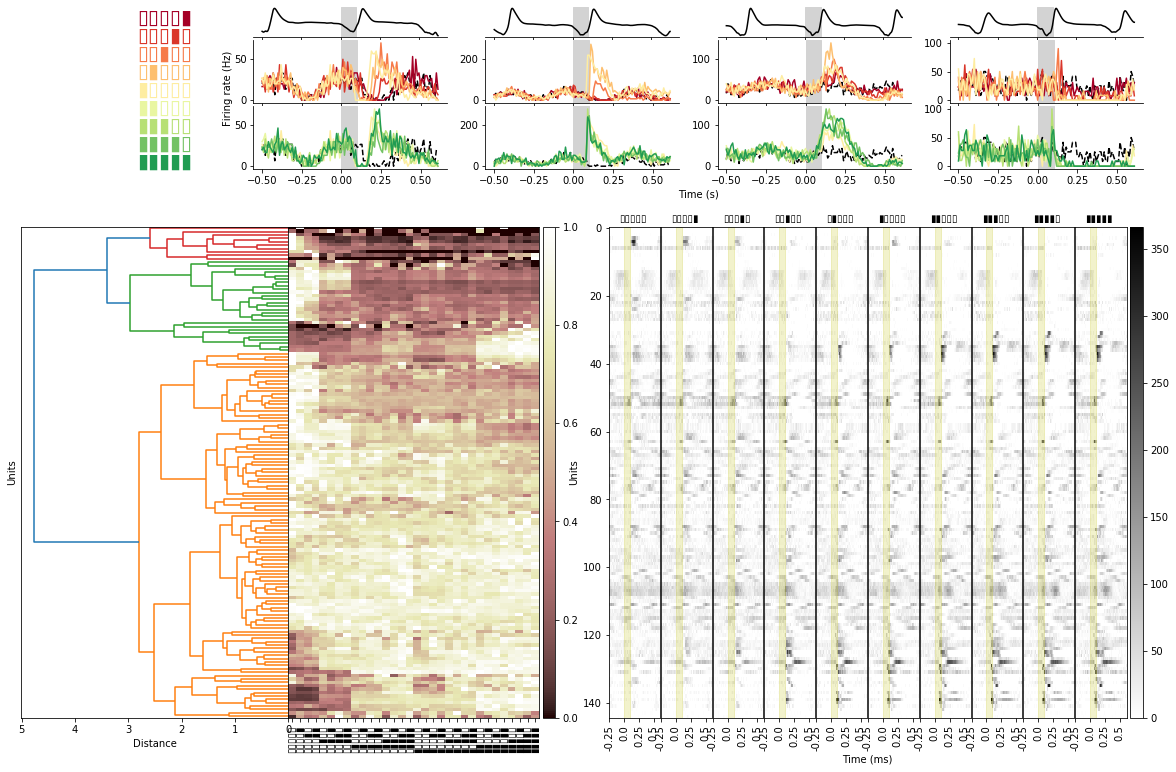

In [18]:

fig = plt.figure(figsize=(8.3, 11.7))
gs = GridSpec(9, 5, figure=fig, hspace=1.1, left=0.03, right=0.97, bottom=0.1, top=0.99)
mouse_ax = fig.add_subplot(gs[:2, :2])
mouse_ax.set_xticks([])
mouse_ax.set_yticks([])
blip_ax = fig.add_subplot(gs[:2, 2:4])
for i in range(32):
    blip_ax.text(int(i/8)+0.1, 8-i%8-0.5, glyphs[i], fontsize=11)
blip_ax.set_xlim(0, 4)
blip_ax.set_ylim(0, 8)
blip_ax.axis('off')

odour_ax1 = fig.add_subplot(gs[:2, 4])
odour_ax2 = fig.add_subplot(gs[2:4, 4:15], sharex=odour_ax1, sharey=odour_ax1)
odour_ax3 = fig.add_subplot(gs[4:6, 12:15], sharex=odour_ax1, sharey=odour_ax1)
plt.setp(odour_ax1.get_xticklabels(), visible=False)
plt.setp(odour_ax2.get_xticklabels(), visible=False)
odour_ax1 = plot_pid_and_flow(3, odour_ax1)
odour_ax2 = plot_pid_and_flow(21, odour_ax2)
odour_ax3 = plot_pid_and_flow(31, odour_ax3)
sorted_args = np.argsort(np.argmax(mean_usrt1[:, select_trials[::-1][-1]], axis=-1))


stim_ax = fig.add_subplot(gs[:2, 0])
#stimuli_plot(stim_ax, plots_all)
stimuli_plot_glyphs(stim_ax, glyphs, select_trials)
xs = np.arange(-.5, .62, 1/100)[:-1]
plot_psth(fig, gs[:2, 1], units_usrt1, select_trials, sorted_args[-38], xs, resp=filt_snips[0])
plot_psth(fig, gs[:2, 2], units_usrt1, select_trials, 42, xs, resp=filt_snips[1])
plot_psth(fig, gs[:2, 3], units_usrt1, select_trials, sorted_args[99], xs, resp=filt_snips[2])
plot_psth(fig, gs[:2, 4], units_usrt1, select_trials, sorted_args[5], xs, resp=filt_snips[3])
psth_ax = fig.add_subplot(gs[:2, 1:], frameon=False)
psth_ax.set_xticks([])
psth_ax.set_yticks([])
psth_ax.set_ylabel('Firing rate (Hz)', labelpad=20)
psth_ax.set_xlabel('Time (s)', labelpad=20)
dendo_and_heatmaps(fig, gs[2:, :], link, summed_response1)
plt.autoscale(tight=True)
#plt.savefig('221109_neural_responses.pdf')